In [ ]:
import pandas as pd 
#add GPU command
import tensorflow as tf
import torch
!pip install transformers

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
#importing the data
tsv_read = pd.read_csv("train.tsv", sep='\t')
df = tsv_read

#splitting train and test data 
n = len(df)
n_train = int(n*0.8)
df_train = df[0:n_train]

print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))

Number of training sentences: 124,848



In [ ]:
#balancing the data by reducing sentences belonging to "neutral" class


#np.random.seed(10)

#remove_n = 40000
#drop_indices = np.random.choice(df[df['Sentiment']==2].index, remove_n, replace=False)
#df_subset = df.drop(drop_indices)
#df = df_subset

In [ ]:
phrases = df_train.Phrase.values
labels = df_train.Sentiment.values
print(phrases)

['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'
 'A series of escapades demonstrating the adage that what is good for the goose'
 'A series' ...
 "proves once again that he 's the best brush in the business"
 "once again that he 's the best brush in the business"
 "that he 's the best brush in the business"]


In [ ]:
#importing BERT Tokenizer
from transformers import BertTokenizer
from transformers import XLNetForSequenceClassification

#bert tokenzier
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
#tokenizing sentences and map the tokens to IDs.
input_ids = []
for phrase in phrases:
    encoded_phrase = tokenizer.encode(
                        phrase,         
                        add_special_tokens = True, # adding CLS and SEP
                   )
    
    #appending the encoded phrases to input_ids list
    input_ids.append(encoded_phrase)

In [ ]:
#finding maximum sentence length
max_train = max([len(phrase) for phrase in input_ids])
print(max_train)

In [ ]:
#padding the sequences so they have the same length
max_length = 35


#importing pad_squences
from keras.preprocessing.sequence import pad_sequences

#padding with value 0 at end of sequence
input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", 
                          value=0, truncating="post", padding="post")


In [ ]:
#creating attention masks

#initialising attention_masks
att_masks = []
for phrase in input_ids:
    #for non-zero token IDs, set mask to 1
    masks = [int(token_id > 0) for token_id in phrase]    
    # appending to att_masks
    att_masks.append(masks)


In [ ]:
#splitting data train and validation
#importing train_test_split 
from sklearn.model_selection import train_test_split
#80% train, 20% validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=1, test_size=0.2)
#same split for masks
train_masks, validation_masks, _, _ = train_test_split(att_masks, labels,
                                             random_state=1, test_size=0.2)

In [ ]:
#converting into torch tensors (type = long) 
train_inputs = torch.tensor(train_inputs,  dtype=torch.long)
validation_inputs = torch.tensor(validation_inputs,  dtype=torch.long)
train_labels = torch.tensor(train_labels,  dtype=torch.long)
validation_labels = torch.tensor(validation_labels,  dtype=torch.long)
train_masks = torch.tensor(train_masks,  dtype=torch.long)
validation_masks = torch.tensor(validation_masks,  dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#setting batch size to 64
batch_size = 64
#creating dataloader for training data
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
#creating dataloader for validation data
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

#pretrained BERT model for sequences classification
#num_labels is 5 since we have 5 output classes 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 5, 
    output_attentions = True, 
    output_hidden_states = True,
)

#to run on GPU
model.cuda()

In [ ]:
#using AdamW optimiser to fine-tune the model
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup
#number of training epochs
epochs = 4
#total steps 
total_steps = len(train_dataloader) * epochs
#creating learning rate schedule
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

#calculating accuracy by averaging the correctly classified obs over the number of labels
def accuracy_score(predictions, labels):
    pred = np.argmax(predictions, axis=1).flatten()
    labs = labels.flatten()
    return np.sum(predictions == labs) / len(labs)

In [ ]:
#Training

import random
#setting sed to 1
seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
#torch.cuda.manual_seed_all(seed_val)
#initialising average loss at each epoch.
loss_values = []
for i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))

    #resetting total loss
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        #updating training loss
        if step % 10 == 0 and not step == 0: 
            #reporting progress
            print(f"batch number {step} of {len(train_dataloader)}")
        
        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        model.zero_grad()        
        #Forward pass to return the loss
        outputs = model(batch_input_ids, 
                    token_type_ids=None, 
                    attention_mask=batch_input_mask, 
                    labels=batch_labels)
        
        #retrieving loss value
        loss = outputs[0]
        #calculating average loss over all batches
        total_loss += loss.item()



        #backward pass to calculate gradients
        loss.backward()
        #clipping gradients to 1 to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        #updating parameters
        optimizer.step()
        #updating learning rate
        scheduler.step()
    #calculating average loss over all the training data
    avg_train_loss = total_loss / len(train_dataloader)            
    
    #appending avg_train_loss to loss_values
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
        

In [ ]:
    #Validation

    model.eval()
    #Initialising variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    val_accuracy = []
  

    for batch in validation_dataloader:
        
        #adding to GPU
        batch = tuple(t.to(device) for t in batch)
        #batch = tuple(batch)
        
        # retrieving inputs from dataloader
        batch_input_ids, batch_input_mask, batch_labels = batch
        with torch.no_grad():        
            #Forward pass to calculate logit predicitions (output values before
            #applying activation function)
            outputs = model(batch_input_ids, 
                            token_type_ids=None, 
                            attention_mask=batch_input_mask)
        # retrieveing logits
        logits = outputs[0]
        # move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        
        # calculating accuracy per batch
        accuracy_batch = accuracy_score(logits, label_ids)
        
        # appending total accuracy.
        val_accuracy.append(accuracy_batch)
        # number of batches
        nb_eval_steps += 1
    # final accuracy
    print("  Accuracy: {0:.2f}".format(sum(val_accuracy)/nb_eval_steps))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


  Accuracy: 0.00


In [ ]:
# performance on test set
df_test = df[n_train+1:n]

# creating phrases and label lists
phrases = df_test.Phrase.values
labels = df_test.Sentiment.values
# tokenizing to map to input_ids
input_ids = []
for phrase in phrases:
    encoded_phrase = tokenizer.encode(
                        phrase,                      
                        add_special_tokens = True,
                   )
    
    input_ids.append(encoded_phrase)
# padding tokens
input_ids = pad_sequences(input_ids, maxlen=max_length, 
                          dtype="long", truncating="post", padding="post")
# creating attention masks
att_masks = []
# create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  att_masks.append(seq_mask) 
# converting everything to tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(att_masks)
prediction_labels = torch.tensor(labels)
# setting batch size to 64
batch_size = 64  
# creating the dataloader
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set
model.eval()
# initialising variables
predictions , true_labels = [], []
# prediciting
for batch in prediction_dataloader:
  # adding to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # retrieve inputs from dataloader
  batch_input_ids, batch_input_mask, batch_labels = batch
  with torch.no_grad():
      # Forward pass to calculate logit predicitions
      outputs = model(batch_input_ids, token_type_ids=None, 
                      attention_mask=batch_input_mask)
  logits = outputs[0]
  # moving logits to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = batch_labels.to('cpu').numpy()
  
  # appending logits and b_labels to predcictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
import torch.nn.functional as F
# Concatenate logits from each batch
cat_logits = np.concatenate(predictions)

# Apply softmax to calculate probabilities
probs = F.softmax(torch.tensor(cat_logits), dim=1).numpy()

max_list = probs.max(axis=1)
max_index = probs.argmax(axis=1)
print(max_list)
print(max_index)

[0.7483043  0.55878067 0.83428884 ... 0.7642161  0.6698374  0.7084904 ]
[3 3 3 ... 2 3 2]


In [ ]:
true_labels = df_test.Sentiment
#print(true_labels)
predicted_labels = max_index

correct_labels = sum(true_labels == predicted_labels)/len(predicted_labels)*100
print(correct_labels)

65.76527506327898


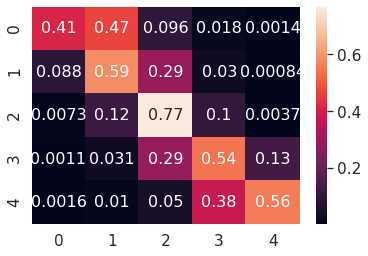

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

cm_bert = confusion_matrix(true_labels, predicted_labels, normalize='true')
cm1_bert = confusion_matrix(true_labels, predicted_labels)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm_bert, range(5), range(5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [ ]:
# accuracy, recall and precision

accuracy=sum(np.diag(cm1_bert))/np.sum(cm1_bert)
print("Accuracy is", accuracy*100, "%")

recall = np.zeros(5)
precision = np.zeros(5)
for i in range(5):
  recall[i] = round((cm1_bert[i, i] / np.sum(cm1_bert[:, i])) * 100, 2)
  precision[i] = round((cm1_bert[i, i] / np.sum(cm1_bert[i, :])) * 100, 2)

recall = pd.DataFrame(recall)
precision = pd.DataFrame(precision)
eval = pd.concat([recall, precision], axis = 1)
eval.columns = ['Recall (%)', 'Precision (%)']
print(eval)

Accuracy is 65.76527506327898 %
   Recall (%)  Precision (%)
0       48.23          41.44
1       56.16          58.82
2       75.22          76.81
3       59.01          54.41
4       52.81          55.97


In [ ]:
# testing model on unseen input

new_input = "insert unseen input sentence here"

# tokenizing to map to input_ids
input_id = tokenizer.encode(
                        new_input,                      
                        add_special_tokens = True)
input_id = np.array(input_id)
input_id = np.reshape(input_id, (1, -1))
# padding tokens
input_id = pad_sequences(input_id, maxlen=max_length, 
                          dtype="long", truncating="post", padding="post")
# creating attention masks
att_masks = []
# create a mask of 1s for each token followed by 0s for padding
att_masks = [float(i>0) for i in input_id[0, :]] 
#converting everything to tensors
prediction_input = torch.tensor(input_id)
prediction_masks = torch.tensor(att_masks)
prediction_masks = torch.reshape(prediction_masks, (1, 35))

# predicting label for unseen input
prediction_input = prediction_input.to(device)
prediction_masks = prediction_masks.to(device)
model = model.to(device)
outputs = model(prediction_input, token_type_ids=None, 
                      attention_mask=prediction_masks)
predicition_logits = outputs[0]


# softmax through logit
import torch.nn.functional as F

# apply softmax to calculate probabilities
probs = F.softmax(torch.tensor(predicition_logits), dim=1)
probs = probs.cpu()
probs = probs.numpy()

max_list = probs.max(axis=1)
max_index = probs.argmax(axis=1)

print(f"Sentiment prediction of unseen input is {max_index}")